# Imports


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from general import GeneralUtil as util

# Constants


In [ ]:
# Set the classes
classes = ("A", "B", "C", "D", "E")
# GPU Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ROOT_DIR = "/kaggle/working/American-Sign-Language-Recogniztion-CNN"
TRAINING_PATH = f"{ROOT_DIR}/images/training"
TESTING_PATH = f"{ROOT_DIR}/images/testing"

# Homebrewed Functions


In [ ]:
def display_sample_image(imageloader, n=1):
    """Display a sample of the images in the given image loader"""
    plt.rcParams["figure.figsize"] = (10, 10)

    def _imshow(img):
        img = img / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    for _ in range(n):
        # get some random images
        dataiter = iter(imageloader)
        images, labels = next(dataiter)

        # show images
        _imshow(torchvision.utils.make_grid(images))
        # print labels
        print(" ".join("%12s" % classes[labels[j]] for j in range(len(images))))


def plot_acc_loss(train_accs, test_accs, train_losses, test_losses, caption):
    """Plot the accuracy and loss"""
    # Visualize the loss / acc
    plt.figure()
    plt.plot(train_accs, label="Train")
    plt.plot(test_accs, label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Classification Accuracy vs Epoch: {}".format(caption))

    # Visualize the loss / acc
    plt.figure()
    plt.plot(train_losses, label="Train")
    plt.plot(test_losses, label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("Cross Entropy Loss")
    plt.legend()
    plt.title("Cross Entropy Loss vs Epoch: {}".format(caption))

    return


def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

## Train & Validate


In [ ]:
def train(device=torch.device("cpu"), scheduler=None):
    net.train()
    #     progress_bar = tqdm.notebook.tqdm(train_loader, leave=False)
    running_loss = 0.0
    correct = 0
    total = 0

    #     for inputs, data in progress_bar:
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        # Calcualte accuracy
        _, predicted = torch.max(outputs.data.detach().cpu(), 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # print statistics
        running_loss += loss.item()

    training_loss.append(running_loss / i)
    training_acc.append(100.0 * correct / total)

    return running_loss


def validation(val_loader, device=torch.device("cpu"), verbose=False):
    actual = []
    pred = []

    correct = 0
    total = 0
    running_loss = 0.0
    net.eval()

    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images.to(device))

            loss = criterion(outputs, labels.to(device))
            running_loss += loss.item()

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data.detach().cpu(), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # collect the correct predictions for each class
            for label, prediction in zip(labels, predicted):
                if verbose:
                    actual.append(label.item())
                    pred.append(prediction.item())
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    if verbose:
        print("==" * 30)
        print(f"Accuracy of the network on the test images: {100 * correct / total}%")
        print("==" * 30)
        # print accuracy for each class
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname]
            print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))
        print("==" * 30)
        plot_confusion_matrix(actual, pred)

    if not verbose:
        val_acc.append(100.0 * correct / total)
        val_loss.append(running_loss / len(val_loader))

    return running_loss / len(val_loader)


def save_model(net, PATH=f"{ROOT_DIR}/models/", name="asl_cnn.pth"):
    torch.save(net.state_dict(), PATH + name)


def load_model(net, name, PATH=f"{ROOT_DIR}/models/"):
    model = net.load_state_dict(torch.load(PATH + name))
    return model

## Load Data


In [ ]:
def load_data(train_path, test_path, batch_size=5):
    # --------------------------------------------------------------------------------------------------
    # Set up transformer to normalize and transform the data
    # --------------------------------------------------------------------------------------------------

    train_transform = transforms.Compose(
        [
            transforms.RandomResizedCrop(
                (500, 500), scale=(0.8, 1.0), ratio=(0.9, 1.1)
            ),
            transforms.ToTensor(),
        ]
    )

    test_transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # --------------------------------------------------------------------------------------------------
    # Create the training and test datasets as well as the data loaders
    # --------------------------------------------------------------------------------------------------
    # Data Sets
    train_dataset = datasets.ImageFolder(TRAINING_PATH, transform=train_transform)
    test_dataset = datasets.ImageFolder(TESTING_PATH, transform=test_transform)
    val_dataset = datasets.ImageFolder(TRAINING_PATH, transform=train_transform)

    torch.manual_seed(42)
    train_set, _ = torch.utils.data.random_split(train_dataset, [310, 50])
    torch.manual_seed(42)  # Think why do we do this?
    _, val_set = torch.utils.data.random_split(val_dataset, [310, 50])

    # Data Loaders
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size,
        drop_last=True,
        pin_memory=False,
        shuffle=True,
        num_workers=2,
    )

    val_loader = torch.utils.data.DataLoader(
        val_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=2,
    )
    util.print(f"Successfully loaded images\nBatch size: {batch_size}", color="green")

    return train_loader, val_loader, test_loader

In [ ]:
train_loader, val_loader, test_loader = load_data(TRAINING_PATH, TESTING_PATH)


Successfully loaded images
Batch size: 5


Let's visualize some of the images in the dataset.


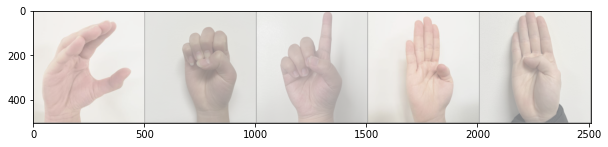

           C            E            D            B            B


In [ ]:
display_sample_image(train_loader, n=1)


# Pre Trained AlexNet


## Load Model


In [ ]:
net = torch.hub.load("pytorch/vision:v0.10.0", "alexnet", pretrained=True)

# NOTE: We have to change the last layer to have an output of 5 as we only have 5 classes.
net.classifier[6] = nn.Linear(4096, 5)
net.to(device)

net.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Model Architecture


## Train Model


In [ ]:
train_loader, val_loader, test_loader = load_data(
    TRAINING_PATH, TESTING_PATH, batch_size=32
)

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)

Training...
Epoch #1	Train Loss: 1.799	Validation Loss: 1.453
Epoch #2	Train Loss: 1.491	Validation Loss: 1.208
Epoch #3	Train Loss: 1.183	Validation Loss: 0.979
Epoch #4	Train Loss: 0.905	Validation Loss: 0.802
Epoch #5	Train Loss: 0.815	Validation Loss: 0.556
Epoch #6	Train Loss: 0.704	Validation Loss: 0.527
Epoch #7	Train Loss: 0.613	Validation Loss: 0.363
Epoch #8	Train Loss: 0.462	Validation Loss: 0.297
Epoch #9	Train Loss: 0.385	Validation Loss: 0.280
Epoch #10	Train Loss: 0.295	Validation Loss: 0.287
Epoch #11	Train Loss: 0.298	Validation Loss: 0.340
Epoch #12	Train Loss: 0.309	Validation Loss: 0.219
Epoch #13	Train Loss: 0.238	Validation Loss: 0.217
Epoch #14	Train Loss: 0.230	Validation Loss: 0.209
Epoch #15	Train Loss: 0.230	Validation Loss: 0.288
Epoch #16	Train Loss: 0.209	Validation Loss: 0.176
Epoch #17	Train Loss: 0.197	Validation Loss: 0.120
Epoch #18	Train Loss: 0.166	Validation Loss: 0.210
Epoch #19	Train Loss: 0.218	Validation Loss: 0.302
Epoch #20	Train Loss: 0.207	

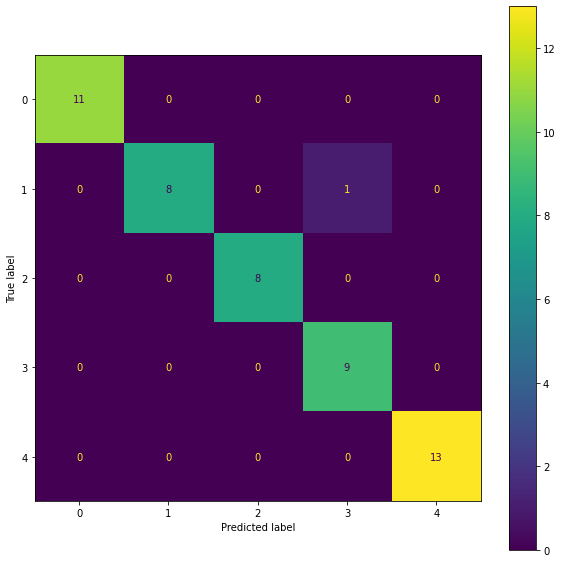

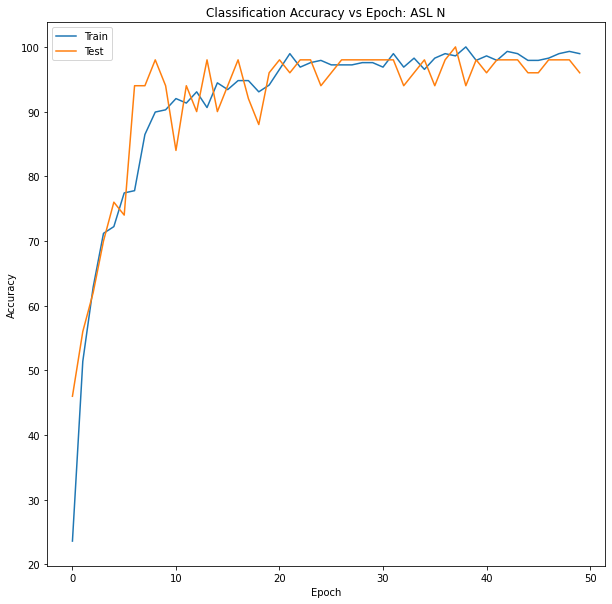

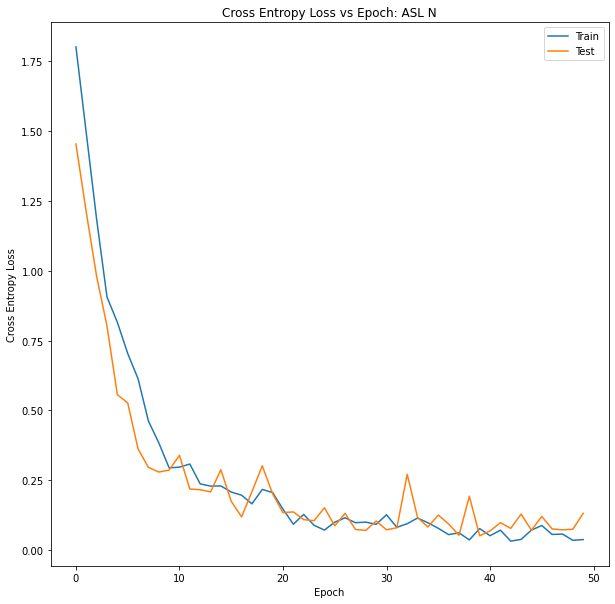

In [ ]:
training_loss = []
training_acc = []
val_acc = []
val_loss = []
EPOCHS = 50

util.print("Training...", header=True, color="cyan")
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    train(device=device)
    validation(val_loader, device=device)
    print(
        f"Epoch #{epoch+1}\tTrain Loss: {training_loss[-1]:.3f}\tValidation Loss: {val_loss[-1]:.3f}"
    )
util.print("Finished Training", color="green")

# Print accuracy and graphs
validation(val_loader, device=device, verbose=True)
plot_acc_loss(training_acc, val_acc, training_loss, val_loss, caption="ASL N")

# Save model
save_model(net, name="alexnet_asl_50_cnn.pth")

#### Using Alex Net pretrained network, we are able to get an even better accuracy on the image classification in only 50 batches. In the model that I built it took much longer for it to reach such a high accuracy.
